In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
import string

In [5]:
!pip install nltk

In [7]:

nltk.download('stopwords')
stop_words = set(stopwords.words('french'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# --- Charger les données ---
file_path = "final_dataset.csv"  # Remplacez par le chemin de votre fichier
df = pd.read_csv(file_path)
print("Aperçu des données :\n", df.head())


Aperçu des données :
     title  rating                                            content  \
0  Helix–       5  commande bien reçu merci pour votre profession...   
1  Helix–       4  Je suis très impressionnée par la qualité de c...   
2  Helix–       5  kthit menou lel khedma ihezli pc o les documen...   
3  Helix–       4  wselni le sac à dos je suis satisfait la quali...   
4  Helix–       5  Très pratique, surtout pour transporter mon or...   

                                     cleaned_content sentiment  
0  commande bien reçu merci pour votre profession...  positive  
1  je suis très impressionnée par la qualité de c...  positive  
2  kthit menou lel khedma ihezli pc le document f...  positive  
3  wselni le sac à do je suis satisfait la qualit...  positive  
4  très pratique surtout pour transporter mon ord...  positive  


In [37]:
# --- Tester la présence de valeurs manquantes ---
print("\nVérification des valeurs manquantes :")
print(df.isnull().sum())


Vérification des valeurs manquantes :
title              0
rating             0
content            0
cleaned_content    0
sentiment          0
dtype: int64


In [38]:
# --- Tester la distribution des sentiments ---
print("\nRépartition des sentiments dans les données :")
print(df['sentiment'].value_counts())



Répartition des sentiments dans les données :
sentiment
positive    923
negative    384
neutral     118
Name: count, dtype: int64



Longueur des textes avant et après prétraitement :


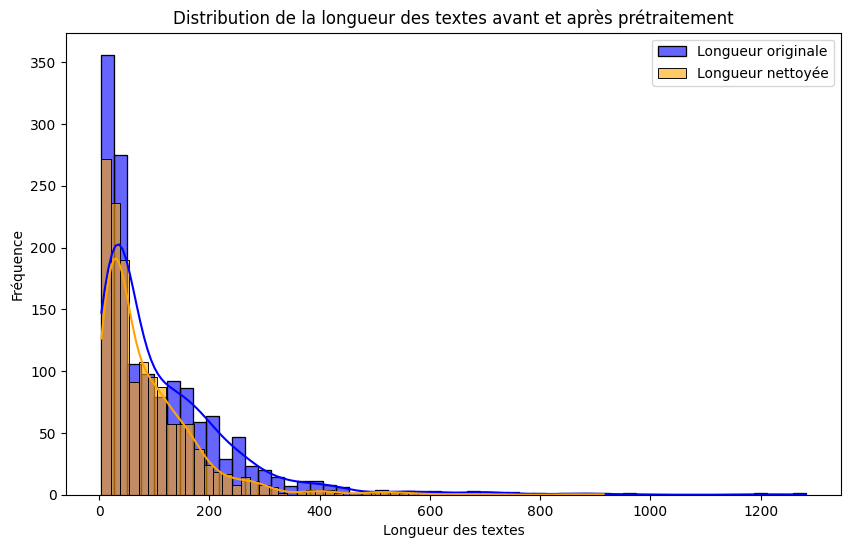


Aperçu des exemples après nettoyage :
                                             content  \
0  commande bien reçu merci pour votre profession...   
1  Je suis très impressionnée par la qualité de c...   
2  kthit menou lel khedma ihezli pc o les documen...   
3  wselni le sac à dos je suis satisfait la quali...   
4  Très pratique, surtout pour transporter mon or...   

                                     cleaned_content  
0  commande bien reçu merci professionnalisme com...  
1  très impressionnée qualité sac tissu étanche p...  
2  kthit menou lel khedma ihezli pc o documents f...  
3        wselni sac dos satisfait qualité excellente  
4  très pratique surtout transporter ordinateur t...  


In [40]:
# Test de la longueur des textes avant et après le prétraitement
print("\nLongueur des textes avant et après prétraitement :")
df['original_length'] = df['content'].apply(len)
df['cleaned_content'] = df['content'].apply(preprocess_text)
df['cleaned_length'] = df['cleaned_content'].apply(len)

# Graphique de la longueur des textes avant et après prétraitement
plt.figure(figsize=(10, 6))
sns.histplot(df['original_length'], kde=True, color='blue', label='Longueur originale', alpha=0.6)
sns.histplot(df['cleaned_length'], kde=True, color='orange', label='Longueur nettoyée', alpha=0.6)
plt.title('Distribution de la longueur des textes avant et après prétraitement')
plt.xlabel('Longueur des textes')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

# --- Tester si le nettoyage des textes est correct (exemples manuels) ---
print("\nAperçu des exemples après nettoyage :")
print(df[['content', 'cleaned_content']].head())

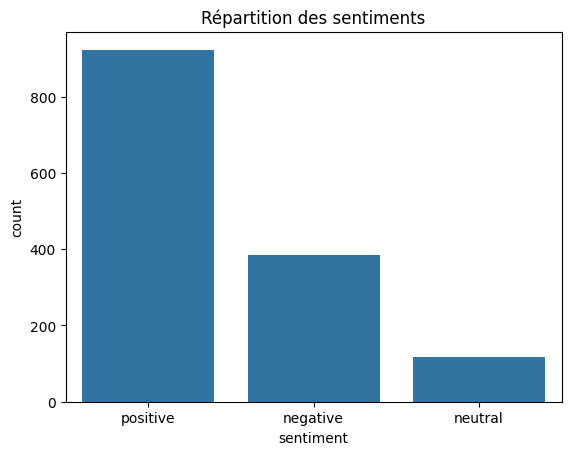

In [10]:
# --- Distribution des sentiments ---
sns.countplot(data=df, x='sentiment')
plt.title('Répartition des sentiments')
plt.show()


In [11]:
# --- Préparation des données ---
X = df['cleaned_content']
y = df['sentiment']


In [12]:
# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Vectorisation avec TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [14]:
# --- Entraînement du modèle ---
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [15]:
# --- Prédictions ---
y_pred = model.predict(X_test_tfidf)


In [16]:
# --- Évaluation ---
print("Rapport de classification :\n", classification_report(y_test, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("Précision : {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))


Rapport de classification :
               precision    recall  f1-score   support

    negative       0.92      0.39      0.55        85
     neutral       1.00      0.93      0.96        28
    positive       0.76      0.98      0.86       172

    accuracy                           0.80       285
   macro avg       0.89      0.77      0.79       285
weighted avg       0.83      0.80      0.77       285

Matrice de confusion :
 [[ 33   0  52]
 [  0  26   2]
 [  3   0 169]]
Précision : 80.00%


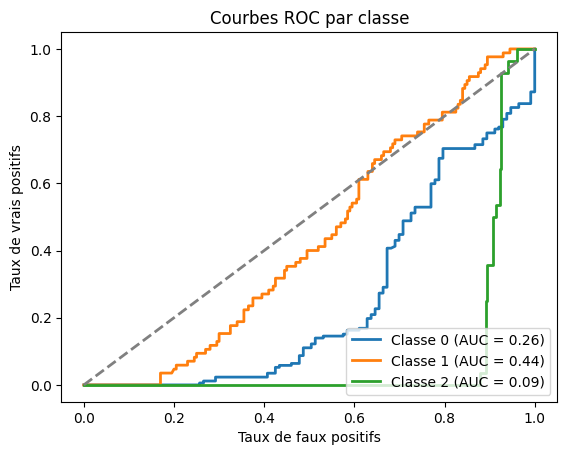

In [31]:
# --- Visualisation des courbes ROC/AUC ---
# Binarisation des labels
y_test_bin = label_binarize(y_test, classes=df['sentiment'].unique())
y_pred_prob = model.predict_proba(X_test_tfidf)

plt.figure()
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.title('Courbes ROC par classe')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.legend(loc='lower right')
plt.show()

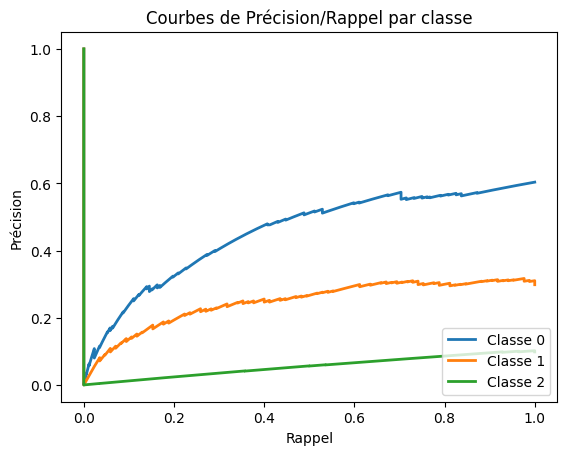

In [32]:

# --- Courbe de précision/rappel ---
plt.figure()
for i in range(y_test_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'Classe {i}')

plt.title('Courbes de Précision/Rappel par classe')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.legend(loc='lower right')
plt.show()

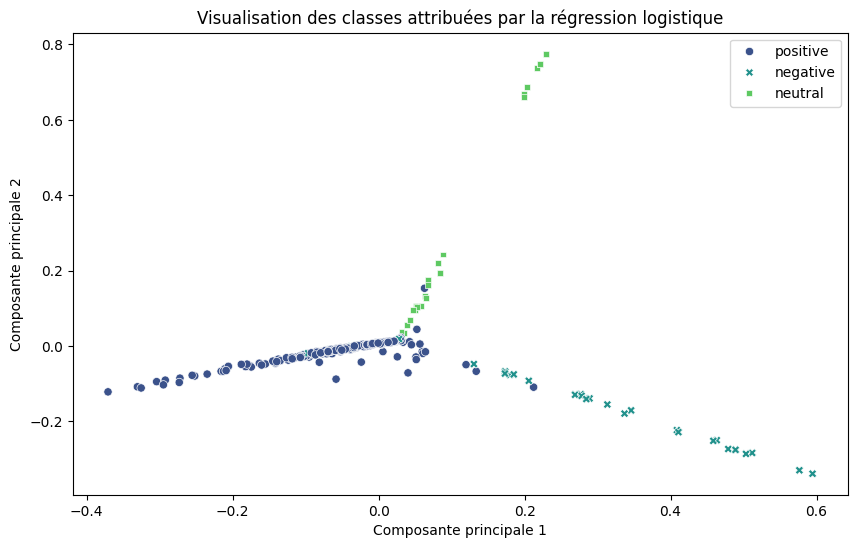

In [33]:
# --- Visualisation des classes prédites ---
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_test_tfidf.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_pred, palette='viridis', style=y_pred)
plt.title('Visualisation des classes attribuées par la régression logistique')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()


In [36]:
# --- Tester des exemples personnalisés ---
examples = [
    "Ce produit est vraiment excellent, je le recommande fortement.",
    "tres mal.",
    "Le produit est correct, mais la qualité pourrait être meilleure.",
    "Produit fantastique, très satisfait !",
    "Je ne suis pas content du tout."
]

examples_cleaned = [preprocess_text(text) for text in examples]
examples_tfidf = tfidf.transform(examples_cleaned)
predictions = model.predict(examples_tfidf)

for text, prediction in zip(examples, predictions):
    print(f"Texte : {text}")
    print(f"Sentiment prédit : {prediction}")

Texte : Ce produit est vraiment excellent, je le recommande fortement.
Sentiment prédit : positive
Texte : tres mal.
Sentiment prédit : positive
Texte : Le produit est correct, mais la qualité pourrait être meilleure.
Sentiment prédit : positive
Texte : Produit fantastique, très satisfait !
Sentiment prédit : positive
Texte : Je ne suis pas content du tout.
Sentiment prédit : positive
